In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 

In [2]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Concatenate the train and test dataframes so the preprocessing is applied to both 
full_data = pd.concat([train_data,test_data]).reset_index(drop = True)

sale_price = train_data['SalePrice'].reset_index(drop=True)
# Remove the Sale Price dependent variable from the combined dataset 
del full_data['SalePrice']

print(f'Train dataframe contains {train_data.shape[0]} rows and {train_data.shape[1]} columns.\n')
print(f'Test dataframe contains {test_data.shape[0]} rows and {test_data.shape[1]} columns.\n')
print(f'The merged dataframe contains {full_data.shape[0]} rows and {full_data.shape[1]} columns.')

Train dataframe contains 1460 rows and 81 columns.

Test dataframe contains 1459 rows and 80 columns.

The merged dataframe contains 2919 rows and 80 columns.


In [3]:
# Drop columns with more than 45% missing data 
cols_to_drop = []
for column in full_data:
  if full_data[column].isnull().sum() / len(full_data) >= 0.4:
    cols_to_drop.append(column)
full_data.drop(cols_to_drop, axis=1, inplace=True)

print(f'{len(cols_to_drop)} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')

5 columns dropped, the full dataset now comprises of 75 variables.


In [4]:
# Now replace the NA values with the median for the numerical 
# columns and scale the data
scaler = MinMaxScaler()

columns = full_data.columns.values
for column in columns:
  if full_data[column].dtype == np.int64 or full_data[column].dtype == np.float64:
    full_data[column] = full_data[column].fillna(full_data[column].median())
    full_data[column] = scaler.fit_transform(np.array(full_data[column]).reshape(-1,1))

# Print the updated data  
full_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.000000,0.235294,RL,0.150685,0.033420,Pave,Reg,Lvl,AllPub,Inside,...,0.082210,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,WD,Normal
1,0.000343,0.000000,RL,0.202055,0.038795,Pave,Reg,Lvl,AllPub,FR2,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,WD,Normal
2,0.000685,0.235294,RL,0.160959,0.046507,Pave,IR1,Lvl,AllPub,Inside,...,0.056604,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,WD,Normal
3,0.001028,0.294118,RL,0.133562,0.038561,Pave,IR1,Lvl,AllPub,Corner,...,0.047170,0.268775,0.0,0.0,0.0,0.0,0.090909,0.00,WD,Abnorml
4,0.001371,0.235294,RL,0.215753,0.060576,Pave,IR1,Lvl,AllPub,FR2,...,0.113208,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,WD,Normal


12 columns dropped, the full dataset now comprises of 63 variables.


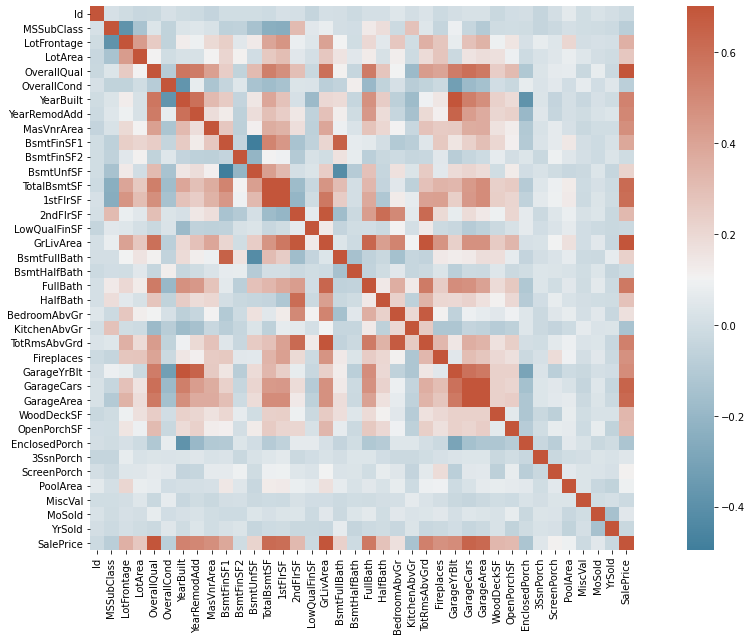

In [5]:
# Calculate the correlation of the numerical variables with the Sale Price 
# Use the training dataset that inludes the Sale Price variable  

corr = train_data.corr()
plt.subplots(figsize=(19,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, vmax=0.7, cmap = cmap, square=True)

cols_to_drop = []
# Get the correlation of the dependent variable with the rest of the features
sale_price_corr = train_data.corr()['SalePrice'][:-1] 

# Drop all the columns from the full data that correlate < |0.12| with the sale price, 
# since will add little value to the model 
for column,row in sale_price_corr.iteritems():
  if abs(float(row)) < 0.12:
    cols_to_drop.append(column)
full_data.drop(cols_to_drop, axis=1, inplace=True)

print(f'{len(cols_to_drop)} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')

In [6]:
count = 0 
columns = full_data.columns.values
for column in columns:
  if full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() > 6:
    count += 1 
    full_data.drop(column, axis = 1, inplace = True)

print(f'{count} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')

9 columns dropped, the full dataset now comprises of 54 variables.


In [7]:
# Replace nas with the most frequent occurring value in the categorical data 
full_data = full_data.fillna(full_data.mode().iloc[0])

In [8]:
# Label / one-hot encode the categorical variables
# One-hot encode the columns that have > 2 categorical variables
# Label-encode the columns that have only 2 categorical variables 

# Instanciating the labelencoder
labelencoder = LabelEncoder()
cols_to_drop = []

columns = full_data.columns.values
for column in columns:
    if full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() > 2: 
      dummies = pd.get_dummies(full_data[column], prefix = str(column))
      cols_to_drop.append(column)
      full_data = pd.concat([full_data, dummies], axis = 1)
    elif full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() < 3: 
      full_data[column] = labelencoder.fit_transform(full_data[column])
      cols_to_drop.append(column)

full_data.drop(cols_to_drop, axis = 1, inplace = True)
print(f'The new dataframe comprises of {test_data.shape[0]} rows and {test_data.shape[1]} columns.\n')

The new dataframe comprises of 1459 rows and 80 columns.



In [9]:
train_df = full_data[:train_data.shape[0]]
test_df =  full_data[train_data.shape[0]:]

In [10]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.008,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

xgb = xgboost.fit(train_df,sale_price)
training_accuracy = xgb.score(train_df,sale_price)
print("Training accuracy: %.2f%%" % (training_accuracy * 100.0))
xgb_predictions = xgb.predict(test_df)

Training accuracy: 99.76%


In [11]:
submission = pd.DataFrame({'ID':test_data['Id'],'SalePrice':xgb_predictions})
submission.to_csv('housepricepred3.csv',index = False)
submission

,ID,SalePrice
0,1461,120699.578125
1,1462,165655.218750
2,1463,187126.125000
3,1464,188307.515625
4,1465,180395.031250
...,...,...
1454,2915,73815.523438
1455,2916,73648.054688
1456,2917,154097.390625
1457,2918,112657.992188
